# Putting It Together



- Download JSON representations of a collection, specificatlly [Selected Digitized Books](https://www.loc.gov/collections/selected-digitized-books/)
- Use pagination (with `next` field) to get the first 5 pages of books
    - Build a big list of item URLs 
- Download individual item JSON from the big list of URLS
    - Save JSON to disk
- Extract individual information from JSON and add to Pandas dataframe
    - Page numbers from the `medium` field
    - requires some string cleaning
- Visualize a histogram of page length of items in the collection
- Save the dataframe as CSV/XSLS to disk

## Load Libraries

In [90]:
import requests
import json
from pathlib import Path

import pandas as pd
%matplotlib inline

## Set Parameters

In [22]:

# Directory for saving files
DATA_DIR = "json-data/"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Depth parameter
PAGE_LIMIT = 5


# HTTP Parameters
BASE_URL = "https://loc.gov"
ENDPOINT = "/collections/selected-digitized-books"
FORMAT = "json"
RESULTS_PER_PAGE = 50

## Fetch Collection Index

* This section fetches JSON representation of the collection and saves it to disk
* It also shows how to do pagination by looping through a range from 1 to PAGE_LIMIT
* Each iteration builds a URL for page based on the parameters set above and the current `page_num`

In [24]:
results_pile = []

for page_num in range(1,PAGE_LIMIT+1):
    
    URL = BASE_URL + ENDPOINT + "/?fo={FORMAT}&c={RESULTS}&sp={PAGE}".format(FORMAT=FORMAT,
                                                                         RESULTS=RESULTS_PER_PAGE,
                                                                         PAGE=page_num)
    print("Fetching", URL)
    response = requests.get(URL)
    collection_index = response.json()
    
    results_pile.
    
    file_name = DATA_DIR + "/index_" + str(page_num) + ".json"
    with open(file_name, 'w') as f:
        json.dump(collection_index, f)

Fetching https://loc.gov/collections/selected-digitized-books/?fo=json&c=50&sp=1
Fetching https://loc.gov/collections/selected-digitized-books/?fo=json&c=50&sp=2
Fetching https://loc.gov/collections/selected-digitized-books/?fo=json&c=50&sp=3
Fetching https://loc.gov/collections/selected-digitized-books/?fo=json&c=50&sp=4
Fetching https://loc.gov/collections/selected-digitized-books/?fo=json&c=50&sp=5


## Fetching Individual Items

* Open the saved index files and extract just the results JSON
* 

In [26]:
# Use a glob pattern to load the index files

collection_indexes = list(Path(DATA_DIR).glob("index_*.json"))
collection_indexes

[PosixPath('json-data/index_1.json'),
 PosixPath('json-data/index_2.json'),
 PosixPath('json-data/index_3.json'),
 PosixPath('json-data/index_4.json'),
 PosixPath('json-data/index_5.json')]

* We can use the `read_text()` function from Pathlib to very quickly suck the JSON data into memory
* This is a shortcut around `with open(index,'r') as f:

In [36]:
# read the files into the JSON parser
results_pile = [json.loads(index.read_text())['results'] for index in collection_indexes]
# Check the length
len(results_pile)

In [42]:
len(results_pile)

250

* We can't actually use a list comprehension here because we are *extending* the list
* A list comprehension would give us a list of lists

In [41]:
# Create a list to hold the result data
results_pile = []
# loop over each index file
for file in collection_indexes:
    # use pathlib to quickly read the file and parse as JSON
    index = json.loads(file.read_text())
    # append all results to the results_pile list
    results_pile.extend(index['results'])
        
# Check the length to make sure everything is loaded
len(results_pile)

* The `fetch_item()` function takes a URL, based on the item ID, and fetches the JSON representation of the item
* It saves the raw JSON to disk as a backup and also returns the JSON representation

In [66]:

def fetch_item(url):
    # add JSON format request
    url = url + "?fo=json"
    # fetch the url
    response = requests.get(url)
    # parse json
    item_json = response.json()
    
    # get the lccn so we can make a unique filename
    lccn = item_json['item']["library_of_congress_control_number"]
    # generate a filename and write json to disk
    filename = DATA_DIR + "item_" + lccn + ".json"
    with open(filename, "w") as f:
        json.dump(item_json, f)
    
    # return the item json
    return item_json

* This is an important line in the program because it loops over the results indexes and fetches all of the items
* This loop takes a while

In [67]:
item_pile = [fetch_item(result['id']) for result in results_pile]

## Load Data Files

* 

In [111]:
item_files = list(Path(DATA_DIR).glob("item_*.json"))
item_files[0]

PosixPath('json-data/item_ltf90006684.json')

In [112]:
def open_item(path):
    
    with open(path, 'r') as f:
        return json.load(f)

In [114]:
item_pile = [open_item(path) for path in item_files]
len(item_pile)

250

In [115]:
keys_of_interest = [
    "library_of_congress_control_number",
    "date",
    "title",
    "medium",
    "created_published",
    "id",
    
    
]
def get_fields(item):
    
    return {key : item['item'][key] for key in keys_of_interest}

In [116]:
data = pd.DataFrame([get_fields(item) for item in item_pile])
data.head(100)

,created_published,date,id,library_of_congress_control_number,medium,title
0,"[Boston, Printed and published by Lincoln & Ed...",1827,http://www.loc.gov/item/ltf90006684/,ltf90006684,[252 p.],"Conversations on natural philosophy, in which ..."
1,"[New York, Printed by Clayton & Van Norden, 18...",1825,http://www.loc.gov/item/ltf90008069/,ltf90008069,[32 p.],An examination of Mr. Dufief's philosophical n...
2,"[Georgetown Heights, D.C., 1860.]",1860,http://www.loc.gov/item/ltf90008097/,ltf90008097,[4 p.],Philosophical views.
3,"[Rochester, New York State Pub. Co., 1900 [c18...",1900,http://www.loc.gov/item/ltf90002975/,ltf90002975,[116 p.],Hypnotism as it is; a book for everybody.
4,"[New York, S.R. Wells, 1875.]",1875,http://www.loc.gov/item/ltf90003010/,ltf90003010,[176 p.],New illustrated self-instructor in phrenology ...
5,"[Philadelphia, Gaut & Volkmar, 1860.]",1860,http://www.loc.gov/item/ltf90007944/,ltf90007944,[24 p.],Psukikos; philosophic observations on the rela...
6,"[Cincinnati, Gazette Co. Print, 1875.]",1875,http://www.loc.gov/item/ltf90007945/,ltf90007945,[28 p.],"The mind; an introductory lecture, delivered N..."
7,"[Chicago, 1867.]",1867,http://www.loc.gov/item/ltf90007948/,ltf90007948,[8 p.],"Scientific explanation of the creed crusher, o..."
8,"[Boston, W. White, 1871.]",1871,http://www.loc.gov/item/ltf90007953/,ltf90007953,[40 p.],What is spiritualism? And shall spiritualists ...
9,"[Chicago, J. Walker, 1868.]",1868,http://www.loc.gov/item/ltf90007976/,ltf90007976,[407 p.],"The trance, and correlative phenomena."


In [117]:
book_lengths = pd.to_numeric(data['medium'].str.get(0).str.split().str.get(0),
                            errors='coerce')
book_lengths.head()

0    252.0
1     32.0
2      4.0
3    116.0
4    176.0
Name: medium, dtype: float64

In [118]:
book_lengths.describe()

count     242.000000
mean      157.438017
std       161.110173
min         1.000000
25%        36.000000
50%       106.000000
75%       225.250000
max      1154.000000
Name: medium, dtype: float64

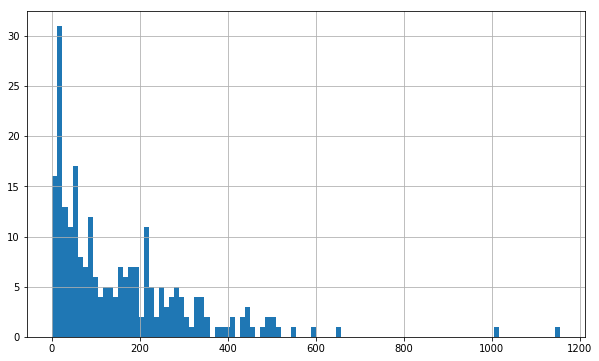

In [119]:
book_lengths.hist(bins=100, figsize=(10,6));